In [1]:
from PIL import Image
from PIL import GifImagePlugin
import numpy as np
import matplotlib.pyplot as plt
import os
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
file_dir="C:/Users/rhish/Downloads/archive/data"
file_list=os.listdir(file_dir)

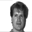

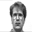

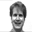

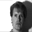

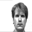

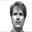

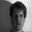

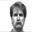

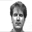

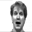

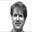

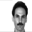

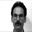

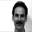

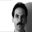

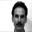

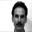

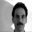

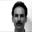

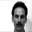

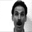

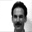

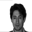

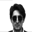

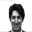

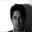

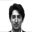

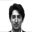

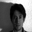

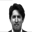

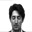

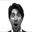

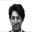

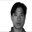

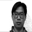

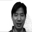

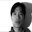

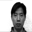

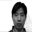

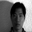

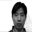

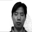

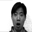

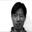

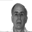

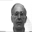

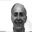

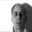

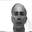

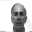

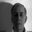

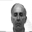

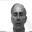

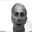

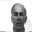

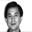

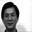

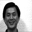

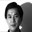

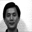

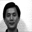

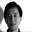

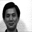

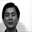

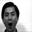

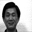

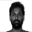

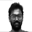

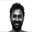

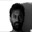

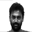

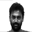

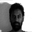

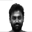

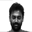

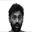

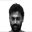

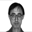

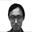

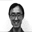

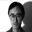

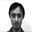

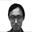

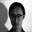

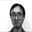

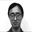

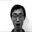

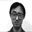

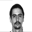

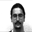

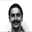

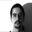

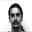

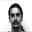

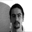

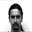

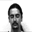

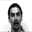

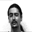

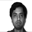

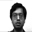

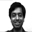

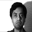

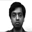

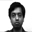

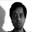

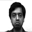

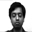

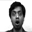

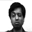

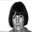

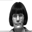

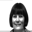

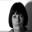

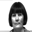

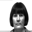

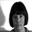

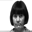

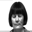

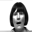

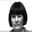

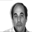

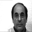

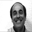

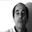

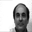

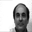

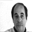

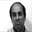

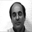

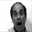

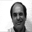

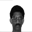

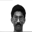

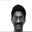

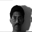

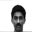

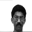

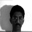

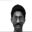

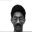

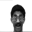

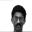

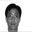

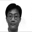

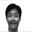

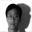

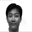

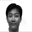

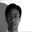

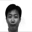

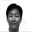

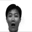

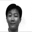

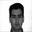

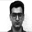

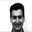

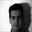

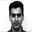

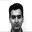

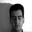

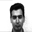

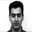

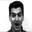

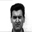

In [2]:
img=[]
for file in file_list:
    if(file=='Readme.txt'):
        continue
    else:
        path=os.path.join(file_dir,file)
        image=Image.open(path)
        image=image.resize((32,32))
        display(image)
        image=np.asarray(image)
        image=image.reshape(-1,)
        img.append(image)

In [3]:
#getting image dimensions as a vector
img[0].shape

(1024,)

In [4]:
labels=[x.split('.')[1] for x in file_list]
labels.remove('txt')
unique_labels=list(set(labels))
unique_labels

['leftlight',
 'centerlight',
 'surprised',
 'rightlight',
 'normal',
 'sad',
 'wink',
 'glasses',
 'sleepy',
 'happy',
 'noglasses']

In [5]:
len(labels)

165

In [6]:
img=np.array(img)
img.shape

(165, 1024)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import pandas as pd
import math
from scipy.linalg import eigh
#returns distance between xi and xj
def dist(xi,xj,sigma=1,method='cosine'):
    if(method=='gauss'):
        return math.e**(np.linalg.norm(xi-xj)**2/2*sigma**2)
    if(method=='cosine'):
        return xi@xj/(np.linalg.norm(xi)*np.linalg.norm(xj))
    
#returns W
def build_graph(data,labels,method='LDA'):
    W=np.zeros((len(data),len(data)))
    if(method=='LDA'):
        unique_labels=list(set(labels))
        count_classes={x:0 for x in unique_labels}
        for i in labels:
            count_classes[i]+=1
        for i in range(len(data)):
            for j in range(i,len(data)):
                if(labels[i]==labels[j]):
                    W[i,j]=1/count_classes[labels[i]]
                    W[j,i]=W[i,j]
                else:
                    W[i,j]=0
                    W[j,i]=0
    if(method=='LPP'):
        knn=KNeighborsClassifier(n_neighbors=1,metric='euclidean')
        knn.fit(data,labels)
        for i in range(len(data)):
            s=0
            for j in range(i,len(data)):
                kj=knn.kneighbors(data[j].reshape((1,-1)))
                ki=knn.kneighbors(data[i].reshape((1,-1)))
                if(j in ki or i in kj):
                    W[i,j]=dist(data[i],data[j])
                    W[j,i]=W[i,j]
                else:
                    W[i,j]=0
                    W[j,i]=0
    sums=[]
    for i in range(len(data)):
        s=0
        for j in range(len(data)):
            if(i!=j):
                s+=W[i,j]
        sums.append(s)
    D=np.zeros((len(data),len(data)))
    for i in range(len(data)):
        D[i,i]=sums[i]
    return W,D

#returns projection matrix
def preprocessing(img,labels,method='PCA',plot=True):
    if(method=='PCA'):
        from sklearn.decomposition import PCA
        pca=PCA(n_components=min(len(img),img[0].shape[0]))
        new_img=pca.fit_transform(img)
        if(plot==True):
            plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
            plt.title("PCA: Plot to choose number of components")
            plt.xlabel('Number of components')
            plt.ylabel('Variance')
            plt.grid()
            plt.show()
        tol=99
        count=0
        for var in np.cumsum(pca.explained_variance_ratio_*100):
            count+=1
            if(var>=tol):
                break
        pca=PCA(n_components=count)
#         print('With tolerance (of variance, in percentage)=',tol,'\nNumber of components chosen for PCA:',count)
        new_img=pca.fit_transform(img)
        return new_img
    
    if(method=='FSSL_LDA' or method=='FSSL_LPP'):
        #number of components=99=feature space in y
        #algo1
        method=method.split('_')[1]
        W,D=build_graph(img,labels,method)
        #continue algo 1 
        Y=eigh(W,D)[1]
        X=img.T
        A_prev=np.zeros(X.shape)
        G_prev=np.identity(A_prev.shape[0])
        niter=0
        max_niter=10000
        while(True):
            
            try:
                A=(np.linalg.inv(G_prev)@X)@(np.linalg.inv(X.T@np.linalg.inv(G_prev)@X)@Y) #Algo 1
#                 A=(np.linalg.inv(G_prev)@X)@np.linalg.inv(X.T@np.linalg.inv(G_prev)@X+1/(2*0.01)*np.identity(len(img)))@Y #Algo 2
            except:
                A=A_prev
                break

            G=np.zeros(G_prev.shape)
            niter+=1
            for i in range(len(G)):
                val=np.linalg.norm(A[i,:])
                if(val==0):
                    G[i,i]=0
                else:
                    G[i,i]=1/val
                    
                G[i,i]+=0.01
                
            if(np.linalg.norm(A-A_prev)<0.1 or niter>max_niter):
                print("Error", np.linalg.norm(A-A_prev))
                break
            print("Error", np.linalg.norm(A-A_prev))
            A_prev=A
            G_prev=G
            print(niter)
        return img@A
        
#returns accuracy and time taken
def baseline(data,labels,tsize,seed):
    start=time.time()
    x_train,x_test,y_train,y_test=train_test_split(data,labels,train_size=tsize,random_state=seed)
    knn=KNeighborsClassifier(n_neighbors=1,metric='euclidean')
    knn.fit(x_train,y_train)
    pred=knn.predict(x_test)
    end=time.time()
    accuracy=accuracy_score(pred,y_test)
    time_taken=round((end-start)*1000,3)
#     print("Accuracy=",accuracy,time_taken)
    return accuracy,time_taken
#returns accuracy and time taken
def LDA(data,labels,tsize,seed):
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    start=time.time()
    data=preprocessing(data,labels,'PCA',False)
    x_train,x_test,y_train,y_test=train_test_split(data,labels,train_size=tsize,random_state=seed)
    lda=LinearDiscriminantAnalysis()
    new_img=lda.fit_transform(data,labels)
    pred=lda.predict(x_test)
    end=time.time()
    accuracy=accuracy_score(pred,y_test)
    time_taken=round((end-start)*1000,3)
#     print("Accuracy=",accuracy,time_taken)
    return new_img,accuracy,time_taken
# def fisher_score(data):
#     nfeatures=len(data[0])
#     nsamples=len(data)
#     for i in range(nfeatures):
#         #comment

In [8]:
def create_table(data,labels,model,choice,extra_time=0):
    train_sizes=[10,20,30]
    table={}
    for size in train_sizes:
        accuracies=[]
        times=[]
        for i in range(20):
            new_data=data
            if(model is LDA):
                new_data,a, t=LDA(data,labels,size/len(data),i)
            if(choice=='LDA'):
                accuracies.append(a)
                times.append(t)
                continue
            else:
                a, t=baseline(new_data,labels,size/len(data),i)
                accuracies.append(a)
                times.append(t+extra_time)
        a=sum(accuracies)/len(accuracies)
        t=str(round(sum(times)/len(times),3))+' ms'
        table[size]=[a,t]
    table=pd.DataFrame(table)
    table=table.rename(index={0:'Accuracy',1:'Time taken'})
    return table

In [9]:
create_table(img,labels,baseline,'base')

10        20        30
Accuracy     0.145161  0.147931  0.162593
Time taken  10.325 ms  6.076 ms  5.101 ms

In [10]:
create_table(img,labels,LDA,'base')

10        20        30
Accuracy    0.354839  0.461379  0.521481
Time taken  4.583 ms  4.071 ms  4.199 ms

In [11]:
create_table(img,labels,LDA,'LDA')

10         20         30
Accuracy     0.789355   0.792759   0.788889
Time taken  45.563 ms  46.589 ms  37.183 ms

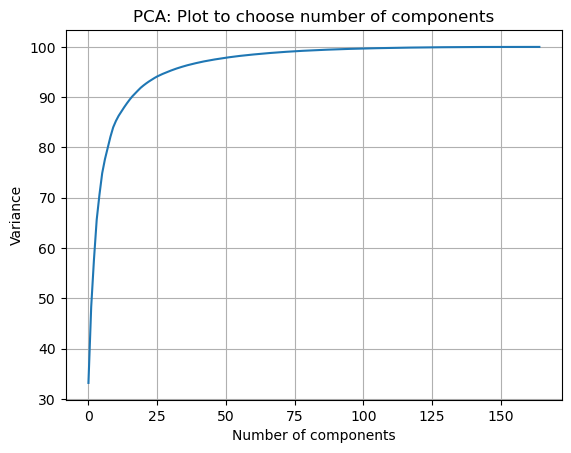

10        20        30
Accuracy    0.144516  0.148276  0.163333
Time taken  4.477 ms  4.267 ms  3.886 ms

In [12]:
create_table(preprocessing(img,labels),labels,baseline,'base')

In [13]:
start=time.time()
fssl_img=preprocessing(img,labels,method='FSSL_LDA')
end=time.time()
extra=end-start
create_table(fssl_img,labels,baseline,'base',extra)

Error 9887218151431074.0
1
Error 9855363392671924.0
2
Error 6.675748184170784e+16
3


10        20        30
Accuracy    0.137419  0.146897  0.153333
Time taken  5.078 ms  5.176 ms  4.769 ms

In [14]:
start=time.time()
fssl_img=preprocessing(img,labels,method='FSSL_LPP')
end=time.time()
extra=end-start
create_table(fssl_img,labels,baseline,'base',extra)

Error 3.465766939425663e+18
1


10         20         30
Accuracy     0.149355    0.16069   0.166667
Time taken  42.434 ms  39.179 ms  38.272 ms

In [15]:
img.shape

(165, 1024)